In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Encoder,Decoder,VAE,CellStateEncoder,CellStateDecoder, CellStateVAE
# import argparse
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

#from scipy.stats import pearsonr
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

#from scipy.stats import pearsonr
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [2]:
device = torch.device('cuda')

In [3]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
cmap = pd.read_csv('cmap_landmarks_HA1E_PC3.csv',index_col = 0)
# cmap = pd.read_csv('cmap_HT29_A375.csv',index_col = 0)

gene_size = len(cmap.columns)
samples = cmap.index.values
# gene_size = len(cmap_tf.columns)
# samples = cmap_tf.index.values

# sampleInfo = pd.read_csv('conditions_HT29_A375.csv',index_col = 0)
sampleInfo_a375 = pd.read_csv('10fold_validation_spit/alldata/pc3_unpaired.csv',index_col=0)
sampleInfo_ht29 = pd.read_csv('10fold_validation_spit/alldata/ha1e_unpaired.csv',index_col=0)
sampleInfo_paired = pd.read_csv('10fold_validation_spit/alldata/paired_pc3_ha1e.csv',index_col=0)

In [4]:
# Network
encoder_a375 = Encoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
decoder_a375 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU())
# encoder_a375 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
# decoder_a375 = Decoder(1024,[2048,4096],gene_size,dropRate=0.2, activation=torch.nn.ELU())
autoencoder_a375 = VAE(encoder_a375,decoder_a375,device).to(device)

In [7]:
# Network
encoder_ht29 = Encoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
decoder_ht29 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU())
# encoder_ht29 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
# decoder_ht29 = Decoder(1024,[2048,4096],gene_size,dropRate=0.2, activation=torch.nn.ELU())
autoencoder_ht29 = VAE(encoder_ht29,decoder_ht29,device).to(device)

In [8]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [9]:
NUM_EPOCHS = 1000
#bs = 512
bs_a375 = 178
bs_ht29 = 154
bs_paired = 90

In [10]:
allParams = list(autoencoder_a375.parameters()) +list(autoencoder_ht29.parameters())
optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)

N_paired = len(sampleInfo_paired)
N_a375 = len(sampleInfo_a375)
N_ht29 = len(sampleInfo_ht29)
N = N_a375
if N_ht29>N:
    N=N_ht29
curLoss = []
curR2 = []
curPearson = []
curMSE = []

In [11]:
stats = {}
stats['loss'] = float('nan')*np.ones(NUM_EPOCHS)
stats['lossSTD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['R2'] = float('nan')*np.ones(NUM_EPOCHS)
stats['R2STD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['pearson_r'] = float('nan')*np.ones(NUM_EPOCHS)
stats['pearson_rSTD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['MSE'] = float('nan')*np.ones(NUM_EPOCHS)
stats['MSESTD'] = float('nan')*np.ones(NUM_EPOCHS)

In [12]:
#randomMSE = torch.mean(torch.mean((x.detach() - torch.mean(x.detach()))**2,dim=1))
#print(randomMSE)

In [13]:
# recon_loss = torch.nn.MSELoss()

In [14]:
for e in range(0, NUM_EPOCHS):
    trainloader_a375 = getSamples(N_a375, bs_a375)
    len_a375 = len(trainloader_a375)
    trainloader_ht29 = getSamples(N_ht29, bs_ht29)
    len_ht29 = len(trainloader_ht29)
    trainloader_paired = getSamples(N_paired, bs_paired)
    len_paired = len(trainloader_paired)

    lens = [len_a375,len_ht29,len_paired]
    maxLen = np.max(lens)

    if maxLen>lens[0]:
        trainloader_suppl = getSamples(N_a375, bs_a375)
        for jj in range(maxLen-lens[0]):
            trainloader_a375.insert(jj,trainloader_suppl[jj])
        
    if maxLen>lens[1]:
        trainloader_suppl = getSamples(N_ht29, bs_ht29)
        for jj in range(maxLen-lens[1]):
            trainloader_ht29.insert(jj,trainloader_suppl[jj])
        
    if maxLen>lens[2]:
        trainloader_suppl = getSamples(N_paired, bs_paired)
        for jj in range(maxLen-lens[2]):
            trainloader_paired.insert(jj,trainloader_suppl[jj])
    #for dataIndex in trainloader:
    for j in range(maxLen):
        dataIndex_a375 = trainloader_a375[j]
        dataIndex_ht29 = trainloader_ht29[j]
        dataIndex_paired = trainloader_paired[j]
            
        df_pairs = sampleInfo_paired.iloc[dataIndex_paired,:]
        df_a375 = sampleInfo_a375.iloc[dataIndex_a375,:]
        df_ht29 = sampleInfo_ht29.iloc[dataIndex_ht29,:]
        paired_inds = len(df_pairs)
                      
        optimizer.zero_grad()
        X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                              cmap.loc[df_a375.sig_id].values))).float().to(device)
        X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                              cmap.loc[df_ht29.sig_id].values))).float().to(device)
            
        z_a375 = autoencoder_a375.encoder(X_a375)
        y_pred_a375 = autoencoder_a375.decoder(z_a375)
        #true_samples_a375 = torch.autograd.Variable(torch.randn(z_a375.shape[0], z_a375.shape[1]), requires_grad=False)
        #true_samples_a375 = true_samples_a375.to(device)
        fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1)) #+ compute_mmd(true_samples_a375,z_a375)
        L2Loss_a375 = autoencoder_a375.L2Regularization(0.01)
        loss_a375 = fitLoss_a375 + L2Loss_a375
        
        z_ht29 = autoencoder_ht29.encoder(X_ht29)
        y_pred_ht29 = autoencoder_ht29.decoder(z_ht29)
        #true_samples_ht29 = torch.autograd.Variable(torch.randn(z_ht29.shape[0], z_ht29.shape[1]), requires_grad=False)
        #true_samples_ht29 = true_samples_ht29.to(device)
        fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1)) #+ compute_mmd(true_samples_ht29,z_ht29)
        L2Loss_ht29 = autoencoder_ht29.L2Regularization(0.01)
        loss_ht29 = fitLoss_ht29 + L2Loss_ht29
        
        #z1_masked = z_a375[np.where(mask>0)[0]]
        #z2_masked = z_ht29[np.where(mask>0)[1]]
        #silimalityLoss = torch.mean(torch.sum((z1_masked - z2_masked)**2,dim=-1))
        silimalityLoss = torch.mean(torch.sum((z_a375[0:paired_inds,:] - z_ht29[0:paired_inds,:])**2,dim=-1))
        
        loss = loss_a375 + loss_ht29 + silimalityLoss

        loss.backward()

        optimizer.step()
        
        pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
        r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
        mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
        pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
        r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
        mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))
        
        curMSE.append(0.5*(mse_a375.item()+mse_ht29.item()))
        curR2.append(0.5*(r2_a375.item()+r2_ht29.item()))
        curPearson.append(0.5*(pearson_a375.item()+pearson_ht29.item()))
        curLoss.append(loss.item())
    scheduler.step()
    #if (e==0 or (e+1)%50==0):
    outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', r2_a375={:.4f}'.format(r2_a375.item())
    outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
    outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
    outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
    outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
    outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
    outString += ', loss={:.4f}'.format(loss.item())
    print(outString)
    stats['loss'][e] = np.mean(np.array(curLoss))
    stats['lossSTD'][e] = np.std(np.array(curLoss))
    stats['pearson_r'][e]= np.mean(np.array(curPearson))
    stats['pearson_rSTD'][e] = np.std(np.array(curPearson))
    stats['R2'][e]= np.mean(np.array(curR2))
    stats['R2STD'][e] = np.std(np.array(curR2))
    stats['MSE'][e]= np.mean(np.array(curMSE))
    stats['MSESTD'][e] = np.std(np.array(curMSE))
    clear_output(wait=True)

Epoch=1000/1000, r2_a375=0.6594, pearson_a375=0.8669, MSE_a375=0.6950, r2_ht29=0.6963, pearson_ht29=0.8725, MSE_ht29=0.6867, loss=1404.8945


In [15]:
autoencoder_ht29.eval()
autoencoder_a375.eval()
print('Evaluate mode')

Evaluate mode


In [4]:
x_a375 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.x']].values,
                                      cmap.loc[sampleInfo_a375.sig_id].values))).float().to(device)
x_ht29 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.y']].values,
                                      cmap.loc[sampleInfo_ht29.sig_id].values))).float().to(device)
z_latent_a375 , xhat_a375 = autoencoder_a375(x_a375)
z_latent_ht29 , xhat_ht29 = autoencoder_ht29(x_ht29)

In [17]:
r2_a375 = r_square(xhat_a375.detach().flatten(), x_a375.detach().flatten())
pearson_a375 = pearson_r(xhat_a375.detach().flatten(), x_a375.detach().flatten())
mse_a375 = torch.mean(torch.mean((xhat_a375 - x_a375)**2,dim=1))
rhos =[]
for jj in range(xhat_a375.shape[0]):
    rho,p = spearmanr(x_a375[jj,:].detach().cpu().numpy(),xhat_a375[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_a375=np.mean(rhos)
acc = pseudoAccuracy(x_a375.detach().cpu(),xhat_a375.detach().cpu(),eps=1e-6)
Accuracy_a375=np.mean(acc)
print('R^2 a375: %s'%r2_a375.item())
print('Pearson correlation a375: %s'%pearson_a375.item())
print('MSE a375: %s'%mse_a375.item())
print('Spearman correlation ht29: %s'%Spear_a375)
print('Pseudo-accuracy ht29: %s'%Accuracy_a375)

R^2 a375: 0.7659645080566406
Pearson correlation a375: 0.9104269742965698
MSE a375: 0.46195900440216064
Spearman correlation ht29: 0.8594056480265815
Pseudo-accuracy ht29: 0.8452481332718589


In [18]:
r2_ht29 = r_square(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
pearson_ht29 = pearson_r(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
mse_ht29 = torch.mean(torch.mean((xhat_ht29 - x_ht29)**2,dim=1))
rhos =[]
for jj in range(xhat_ht29.shape[0]):
    rho,p = spearmanr(x_ht29[jj,:].detach().cpu().numpy(),xhat_ht29[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_ht29=np.mean(rhos)
acc = pseudoAccuracy(x_ht29.detach().cpu(),xhat_ht29.detach().cpu(),eps=1e-6)
Accuracy_ht29=np.mean(acc)
print('R^2 ht29: %s'%r2_ht29.item())
print('Pearson correlation ht29: %s'%pearson_ht29.item())
print('MSE ht29: %s'%mse_ht29.item())
print('Spearman correlation ht29: %s'%Spear_ht29)
print('Pseudo-accuracy ht29: %s'%Accuracy_ht29)

R^2 ht29: 0.8292969465255737
Pearson correlation ht29: 0.9290902614593506
MSE ht29: 0.39680519700050354
Spearman correlation ht29: 0.8825095639034526
Pseudo-accuracy ht29: 0.8593398487209643


In [6]:
paired_inds = len(sampleInfo_paired)

In [11]:
x_a375_equivalent = x_a375[0:paired_inds,:]
x_ht29_equivalent = x_ht29[0:paired_inds,:]
pearDirect = pearson_r(x_a375_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
rhos =[]
for jj in range(x_a375_equivalent.shape[0]):
    rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_ht29_equivalent[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_direct=np.mean(rhos)
acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_a375_equivalent.detach().cpu(),eps=1e-6))
acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_ht29_equivalent.detach().cpu(),eps=1e-6))
print('Pearson of direct translation: %s'%pearDirect.item())
print('Spearman of direct translation: %s'%Spear_direct)
print('Pdeudo-accuracy of direct translation from a375 to ht29: %s'%acc_ht29)
print('Pdeudo-accuracy of direct translation from ht29 to a375: %s'%acc_a375)

Pearson of direct translation: 0.2965739667415619
Spearman of direct translation: 0.3330757228102525
Pdeudo-accuracy of direct translation from a375 to ht29: 0.6143892916899052
Pdeudo-accuracy of direct translation from ht29 to a375: 0.6143892916899052


In [21]:
z_latent_a375_equivalent  = autoencoder_a375.encoder(x_a375_equivalent)
x_hat_ht29_equivalent = autoencoder_ht29.decoder(z_latent_a375_equivalent).detach()
r2_ht29 = r_square(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
pearson_ht29 = pearson_r(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
mse_ht29 = torch.mean(torch.mean((x_hat_ht29_equivalent - x_ht29_equivalent)**2,dim=1))
rhos =[]
for jj in range(x_ht29_equivalent.shape[0]):
    rho,p = spearmanr(x_ht29_equivalent[jj,:].detach().cpu().numpy(),x_hat_ht29_equivalent[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_ht29=np.mean(rhos)
acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_hat_ht29_equivalent.detach().cpu(),eps=1e-6))
print('Pearson correlation A375 to HT29: %s'%pearson_ht29.item())
print('MSE A375 to HT29: %s'%mse_ht29.item())
print('Spearman A375 to HT29: %s'%Spear_ht29)
print('Pdeudo-accuracy A375 to HT29: %s'%acc_ht29)

Pearson correlation A375 to HT29: 0.8515387773513794
MSE A375 to HT29: 0.9414622783660889
Spearman A375 to HT29: 0.7722471348174951
Pdeudo-accuracy A375 to HT29: 0.7957396046353101


In [22]:
z_latent_ht29_equivalent  = autoencoder_ht29.encoder(x_ht29_equivalent)
x_hat_a375_equivalent = autoencoder_a375.decoder(z_latent_ht29_equivalent).detach()
r2_a375 = r_square(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
pearson_a375 = pearson_r(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
mse_a375 = torch.mean(torch.mean((x_hat_a375_equivalent - x_a375_equivalent)**2,dim=1))
rhos =[]
for jj in range(x_a375_equivalent.shape[0]):
    rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_hat_a375_equivalent[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_a375=np.mean(rhos)
acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_hat_a375_equivalent.detach().cpu(),eps=1e-6))
print('Pearson correlation HT29 to A375: %s'%pearson_a375.item())
print('MSE HT29 to A375: %s'%mse_a375.item())
print('Spearman HT29 to A375: %s'%Spear_a375)
print('Pdeudo-accuracy HT29 to A375: %s'%acc_a375)

Pearson correlation HT29 to A375: 0.8482398986816406
MSE HT29 to A375: 0.7838003039360046
Spearman HT29 to A375: 0.7771365850231201
Pdeudo-accuracy HT29 to A375: 0.7961114209580467


Text(0, 0.9, 'r 0.36')

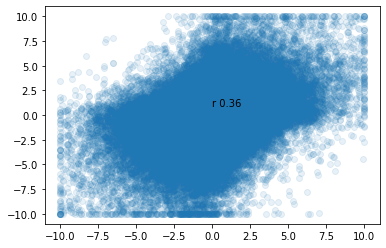

In [10]:
plt.figure()
plt.scatter(x_a375_equivalent.detach().flatten().cpu().numpy(), 
            x_ht29_equivalent.detach().flatten().cpu().numpy(),
            alpha=0.1)
plt.text(0, 0.9, 'r {:.2f}'.format(pearDirect.item()))
plt.savefig('pc3_to_ha1e_direct_correlation_landmarks.png',dpi=600)

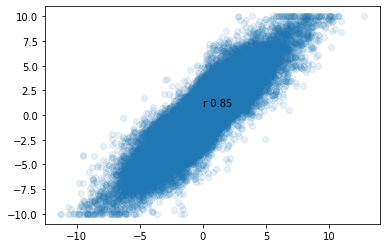

In [24]:
plt.figure()
plt.scatter(x_hat_a375_equivalent.detach().flatten().cpu().numpy(),
            x_a375_equivalent.detach().flatten().cpu().numpy(),
           alpha=0.1)
plt.text(0, 0.9, 'r {:.2f}'.format(pearson_a375.item()))
plt.savefig('ha1e_to_pc3_translate_correlation_landmarks.png',dpi=600)

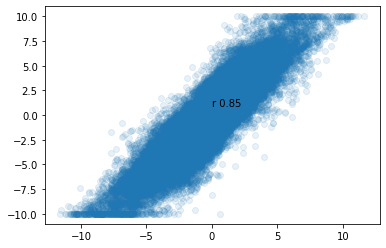

In [25]:
plt.figure()
plt.scatter(x_hat_ht29_equivalent.detach().flatten().cpu().numpy(),
            x_ht29_equivalent.detach().flatten().cpu().numpy(),
           alpha=0.1)
plt.text(0, 0.9, 'r {:.2f}'.format(pearson_ht29.item()))
plt.savefig('pc3_to_ha1e_translate_correlation_landmarks.png',dpi=600)

In [26]:
torch.save(autoencoder_a375, 'AE_PC3_lands.pth')
torch.save(autoencoder_ht29, 'AE_HA1E_lands.pth')

In [25]:
# checkpoint = torch.load('checkpoint_dummyAutoenoderA375_mmd.pth.tar')
# autoencoder.load_state_dict(checkpoint['state_dict'])

In [27]:
def shadePlot(X, Y, STD):
    plt.plot(X, Y)
    curColor = plt.gca().lines[-1].get_color()
    plt.fill_between(X, Y - STD, Y + STD, color=curColor, alpha=0.2)

In [28]:
def movingaverage(values, w):
    moving_averages = np.zeros(values.shape)
    stepsBefore = np.ceil(w/2)
    stepsAfter = np.ceil(w/2)
    for i in range(values.shape[0]):
        start = np.max((i-stepsBefore, 0)).astype(int)
        stop = np.min((i+stepsAfter, values.shape[0])).astype(int)
        moving_averages[i] = np.mean(values[start:stop])
    return moving_averages

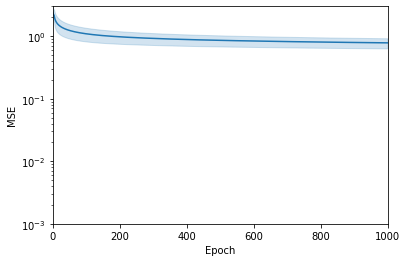

In [29]:
shadePlot(np.array(range(NUM_EPOCHS)), movingaverage(stats['MSE'], 8), movingaverage(stats['MSESTD'], 8))
# plt.plot([0, NUM_EPOCHS], np.array([1, 1])*randomMSE.item(), 'black', linestyle='--')
plt.xlim([0, NUM_EPOCHS])
plt.ylim(bottom=1e-3)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

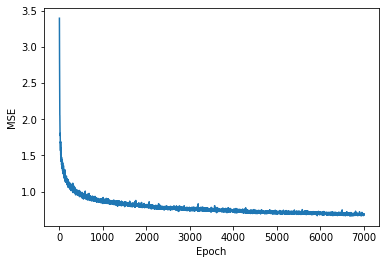

In [30]:
plt.plot(range(len(curMSE)),curMSE)
# plt.plot([0, len(curMSE)], np.array([1, 1])*randomMSE.item(), 'black', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Epoch')
#plt.yscale('log')

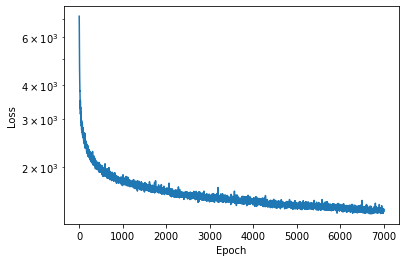

In [31]:
plt.plot(range(len(curLoss)),curLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

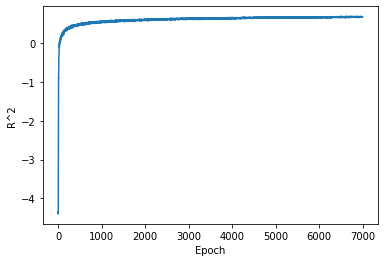

In [32]:
plt.plot(range(len(curR2)),curR2)
plt.ylabel('R^2')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

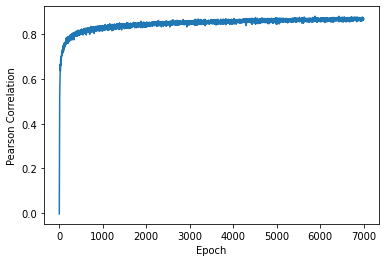

In [33]:
plt.plot(range(len(curPearson)),curPearson)
plt.ylabel('Pearson Correlation')
plt.xlabel('Epoch')

In [34]:
import seaborn as sns
sns.set()

<Figure size 800x400 with 0 Axes>

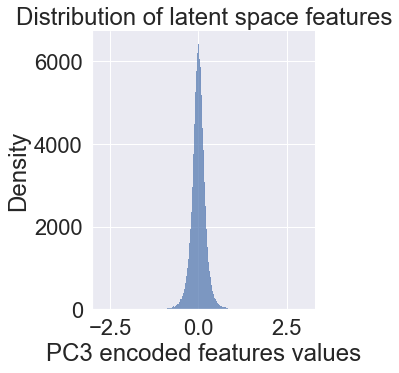

In [35]:
#plt.hist(z_latent_a375.detach().cpu().flatten().numpy())
plt.figure(figsize=(10,5), dpi= 80)
sns.set(font_scale=2)
sns.displot(z_latent_a375.detach().cpu().flatten().numpy())
plt.xlabel('PC3 encoded features values')
plt.ylabel('Density')
plt.title('Distribution of latent space features')
plt.savefig('good_trained_ae_pc3_latent_space_lands.png', bbox_inches='tight',dpi=600)

(array([3.41000e+02, 1.63800e+03, 6.43600e+03, 4.23470e+04, 7.40396e+05,
        6.16767e+05, 3.02520e+04, 4.86100e+03, 1.34500e+03, 1.23000e+02]),
 array([-12.870162  , -10.276506  ,  -7.6828504 ,  -5.089195  ,
         -2.495539  ,   0.09811687,   2.6917727 ,   5.2854285 ,
          7.879084  ,  10.47274   ,  13.066396  ], dtype=float32),
 <BarContainer object of 10 artists>)

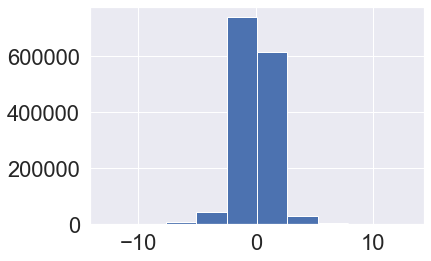

In [36]:
plt.hist(xhat_a375.detach().cpu().flatten().numpy())

(array([  2144.,   4961.,  17627.,  90136., 620823., 603138.,  84699.,
         14973.,   4167.,   1838.]),
 array([-10.000001 ,  -8.000001 ,  -6.0000005,  -4.0000005,  -2.0000002,
          0.       ,   2.0000002,   4.0000005,   6.0000005,   8.000001 ,
         10.000001 ], dtype=float32),
 <BarContainer object of 10 artists>)

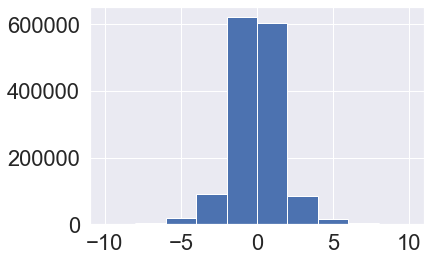

In [37]:
plt.hist(x_a375.detach().cpu().flatten().numpy())

C:\Users\nmeim\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


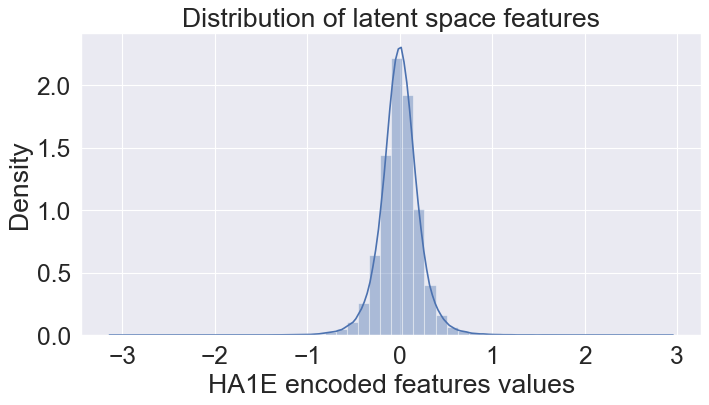

In [38]:
#plt.hist(z_latent_ht29.detach().cpu().flatten().numpy())
plt.figure(figsize=(10,5), dpi= 80)
sns.set(font_scale=2)
sns.distplot(z_latent_ht29.detach().cpu().flatten().numpy())
plt.xlabel('HA1E encoded features values')
plt.ylabel('Density')
plt.title('Distribution of latent space features')
plt.savefig('good_trained_ae_ha1e_latent_space_lands.png', bbox_inches='tight',dpi=600)

(array([4.56000e+02, 2.02000e+03, 6.03500e+03, 3.78060e+04, 5.10281e+05,
        4.46116e+05, 2.74630e+04, 4.19500e+03, 1.16700e+03, 1.63000e+02]),
 array([-12.604189  , -10.065489  ,  -7.526789  ,  -4.988089  ,
         -2.4493892 ,   0.08931065,   2.6280105 ,   5.1667104 ,
          7.7054105 ,  10.24411   ,  12.78281   ], dtype=float32),
 <BarContainer object of 10 artists>)

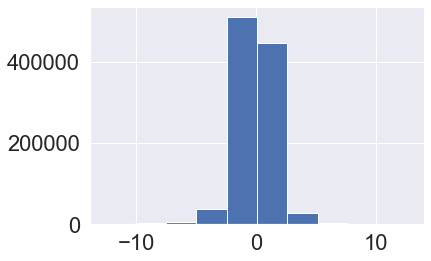

In [39]:
plt.hist(xhat_ht29.detach().cpu().flatten().numpy())

# Important genes : Integrated gradients

In [16]:
import seaborn as sns
sns.set()

In [17]:
encoder_a375=torch.load('MI_results/models/AllData_Model/encoder_pc3.pt')
# encoder_ht29=torch.load('MI_results/models/AllData_Model/encoder_ha1e.pt')
# decoder_a375=torch.load('MI_results/models/AllData_Model/decoder_pc3.pt')
decoder_ht29=torch.load('MI_results/models/AllData_Model/decoder_ha1e.pt')
# decoder_a375.eval()
decoder_ht29.eval()
encoder_a375.eval()
# encoder_ht29.eval()
print('Evaluation mode')

Evaluation mode


In [18]:
# autoencoder_a375 = torch.load('AE_A375_landmarks.pth')
# autoencoder_ht29 = torch.load('AE_HT29_landmarks.pth')
# autoencoder_ht29.eval()
# autoencoder_a375.eval()

x_a375 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.x']].values,
                                      cmap.loc[sampleInfo_a375.sig_id].values))).float().to(device)
x_ht29 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.y']].values,
                                      cmap.loc[sampleInfo_ht29.sig_id].values))).float().to(device)

In [19]:
paired_inds = len(sampleInfo_paired)
len_samples = x_a375.shape[0]

In [20]:
x_a375_equivalent = x_a375[0:paired_inds,:]

In [21]:
# x_ht29_equivalent = x_ht29[0:paired_inds,:]

In [22]:
translator = torch.nn.Sequential(encoder_a375,decoder_ht29)

In [23]:
translator.eval()
ig = IntegratedGradients(translator)
# ig = IntegratedGradients(encoder_a375)

In [12]:
# Per sample captum importance translation
hid_dim = 292
scores = torch.zeros ((paired_inds,gene_size)).to(device)
for z in range(gene_size):
    #translator.zero_grad()
    attr, delta = ig.attribute(x_a375_equivalent,target=z,n_steps=10,return_convergence_delta=True) # 10 steps cause it takes to much time
    scores = scores + torch.abs(attr) # absolute attr (integrated gradient) cause I want to see the score magnitude accros outputs
#grads = grads/gene_size
print(scores)

tensor([[1.0334e-01, 2.6670e-01, 1.9809e+00,  ..., 7.4256e+00, 6.5459e+00,
         1.5385e-01],
        [6.3128e+00, 2.2722e+00, 1.2190e+01,  ..., 6.9177e-03, 3.1380e+00,
         2.4690e+00],
        [1.8528e+01, 1.1589e+00, 5.3851e+00,  ..., 8.3253e+00, 1.7316e+00,
         1.2589e-02],
        ...,
        [7.4505e+00, 1.4007e+00, 7.6488e+00,  ..., 3.4400e+00, 1.1041e+00,
         3.3517e-01],
        [3.5111e-01, 2.3618e+00, 6.3148e+00,  ..., 1.4786e+01, 5.6818e+00,
         3.3877e+00],
        [9.8054e+00, 4.8136e+00, 1.4241e+00,  ..., 2.3435e+00, 9.8339e+00,
         8.4026e-01]], device='cuda:0', dtype=torch.float64)


In [24]:
# Per output gene input importance translation captum
# 1st dimesion input
# 2nd dimesion output
hid_dim = 292
scores = torch.zeros ((gene_size,gene_size)).to(device)
for z in range(gene_size):
    #translator.zero_grad()
    attr, delta = ig.attribute(x_a375_equivalent,target=z,n_steps=10,return_convergence_delta=True) # 10 steps cause it takes to much time
    scores[:,z] = torch.mean(torch.abs(attr),0) #absolute cause I do not care for the sign
print(scores)

tensor([[0.0384, 0.0029, 0.0040,  ..., 0.0055, 0.0042, 0.0021],
        [0.0058, 0.0044, 0.0018,  ..., 0.0024, 0.0039, 0.0010],
        [0.0024, 0.0026, 0.0331,  ..., 0.0046, 0.0098, 0.0029],
        ...,
        [0.0131, 0.0028, 0.0076,  ..., 0.0077, 0.0039, 0.0029],
        [0.0032, 0.0083, 0.0036,  ..., 0.0062, 0.0113, 0.0042],
        [0.0047, 0.0020, 0.0015,  ..., 0.0028, 0.0013, 0.0011]],
       device='cuda:0')


In [11]:
# Per sample captum importance encoding
hid_dim = 292
scores = torch.zeros ((len_samples,gene_size)).to(device)
for z in range(hid_dim):
    #encoder_a375.zero_grad()
    attr, delta = ig.attribute(x_a375,target=z,n_steps=100,return_convergence_delta=True)
    scores = scores +  torch.abs(attr) # absolute attr (integrated gradient) cause I want to see the score magnitude accros outputs
#grads = grads/hid_dim
print(scores)

tensor([[7.9412e-03, 2.1158e-02, 1.6731e-01,  ..., 5.4833e-01, 5.0254e-01,
         1.2538e-02],
        [4.6883e-01, 2.1928e-01, 1.1518e+00,  ..., 5.9693e-04, 2.8731e-01,
         2.3114e-01],
        [1.0831e+00, 8.9000e-02, 4.3668e-01,  ..., 6.7131e-01, 1.3058e-01,
         1.2018e-03],
        ...,
        [7.3586e-01, 2.8846e-01, 5.8302e-02,  ..., 1.4751e-01, 6.6340e-01,
         8.7842e-02],
        [7.4133e-01, 1.5437e-01, 1.7949e-01,  ..., 4.8585e-01, 2.4908e-01,
         2.3661e-01],
        [1.6859e-01, 4.2410e-01, 4.0699e-01,  ..., 3.9870e-01, 4.7182e-01,
         1.3963e-01]], device='cuda:0', dtype=torch.float64)


In [11]:
# Per output latent variable input importance translation captum
# 1st dimesion input
# 2nd dimesion output
hid_dim = 292
scores = torch.zeros ((gene_size,hid_dim)).to(device)
for z in range(hid_dim):
    #encoder_a375.zero_grad()
    attr, delta = ig.attribute(x_a375,target=z,n_steps=100,return_convergence_delta=True)
    scores[:,z] = torch.mean(torch.abs(attr),0) #absolute cause I do not care for the sign
print(scores)

tensor([[0.0014, 0.0026, 0.0009,  ..., 0.0009, 0.0029, 0.0013],
        [0.0017, 0.0007, 0.0003,  ..., 0.0007, 0.0004, 0.0003],
        [0.0017, 0.0012, 0.0005,  ..., 0.0011, 0.0006, 0.0022],
        ...,
        [0.0022, 0.0027, 0.0023,  ..., 0.0014, 0.0024, 0.0015],
        [0.0005, 0.0030, 0.0018,  ..., 0.0006, 0.0020, 0.0004],
        [0.0012, 0.0003, 0.0015,  ..., 0.0023, 0.0018, 0.0005]],
       device='cuda:0')


C:\Users\nmeim\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


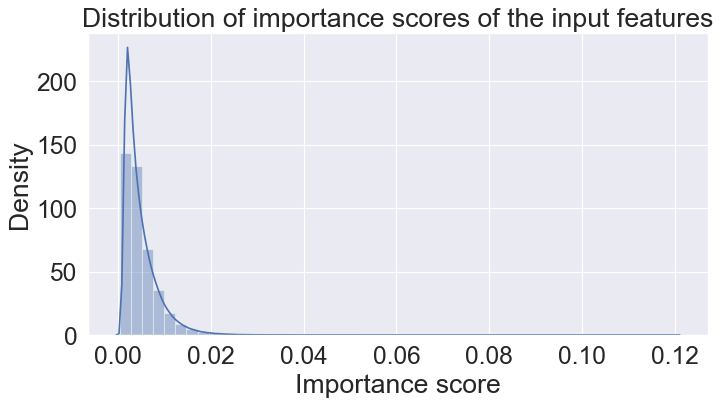

In [25]:
plt.figure(figsize=(10,5), dpi= 80)
sns.set(font_scale=2)
sns.distplot(scores.flatten().cpu().numpy())
plt.xlabel('Importance score')
plt.ylabel('Density')
plt.title('Distribution of importance scores of the input features')
plt.savefig('pc3_to_ha1e_importance_distribution_lands.png', bbox_inches='tight')

In [13]:
# # Helper method to print importances and visualize distribution
# # Taken from https://captum.ai/tutorials/Titanic_Basic_Interpret
# def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
#     print(title)
#     #for i in range(len(feature_names)):
#     #    print(feature_names[i], ": ", '%.3f'%(importances[i]))
#     x_pos = (np.arange(len(feature_names)))
#     if plot:
#         plt.figure(figsize=(12,6))
#         plt.bar(x_pos, importances, align='center')
#         plt.xticks(x_pos, feature_names, wrap=True)
#         plt.xlabel(axis_title)
#         plt.title(title)

# ### Visualize JUST 10 input genes for example
# visualize_importances(list(cmap.columns.values[950:1000]), np.mean(scores.detach().cpu().numpy()[:,950:1000], axis=0))

In [26]:
scores.shape

torch.Size([978, 978])

In [27]:
df = pd.DataFrame(scores.cpu().numpy())
#df.columns = (sampleInfo_paired['sig_id.x'] + '_to_' + sampleInfo_paired['sig_id.y']).values
#df.columns = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_a375['sig_id']) 
df.columns = cmap.columns
# df.index = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_a375['sig_id']) 
#df.columns = ['z'+str(i) for i in range(292)]
df.index = cmap.columns
# df.index = list(sampleInfo_paired['sig_id.x'])
df.to_csv('important_scores_pc3_to_ha1e_lands.csv')